In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
train_df = pd.read_csv('../../data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv', index_col='session_id')

In [5]:
sites = ['site%s' % i for i in range(1, 11)]
times = ['time%s' % i for i in range(1, 11)]

train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

train_df = train_df.sort_values(by='time1')

with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

In [4]:
graph_train = train_df.copy()
graph_train['start_time'] = [d.hour for d in graph_train['time1']]

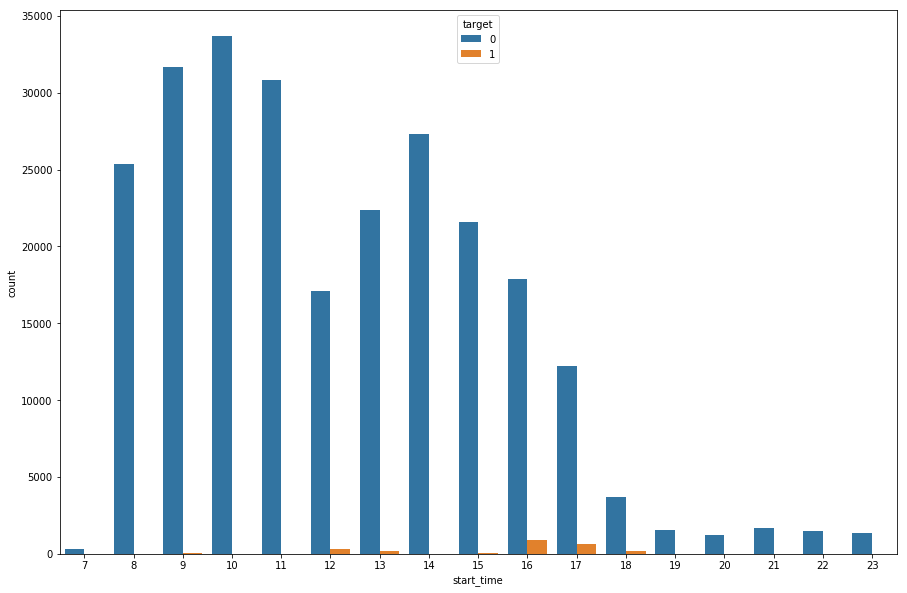

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(x='start_time', hue='target', data=graph_train);

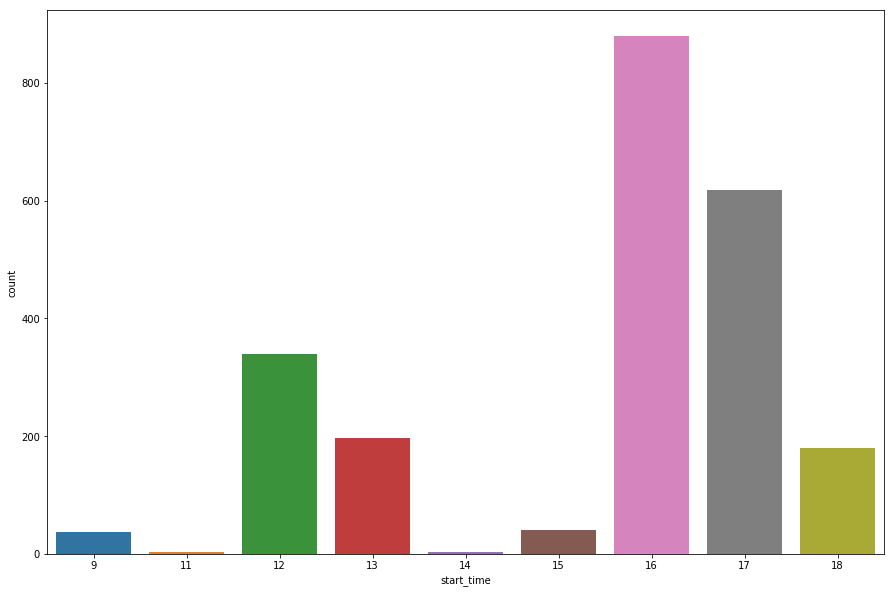

In [6]:
plt.figure(figsize=(15,10))
sns.countplot(x='start_time', data=graph_train[graph_train['target'] == 1]);

In [7]:
graph_train['weekday'] = [d.weekday() for d in graph_train['time1']]

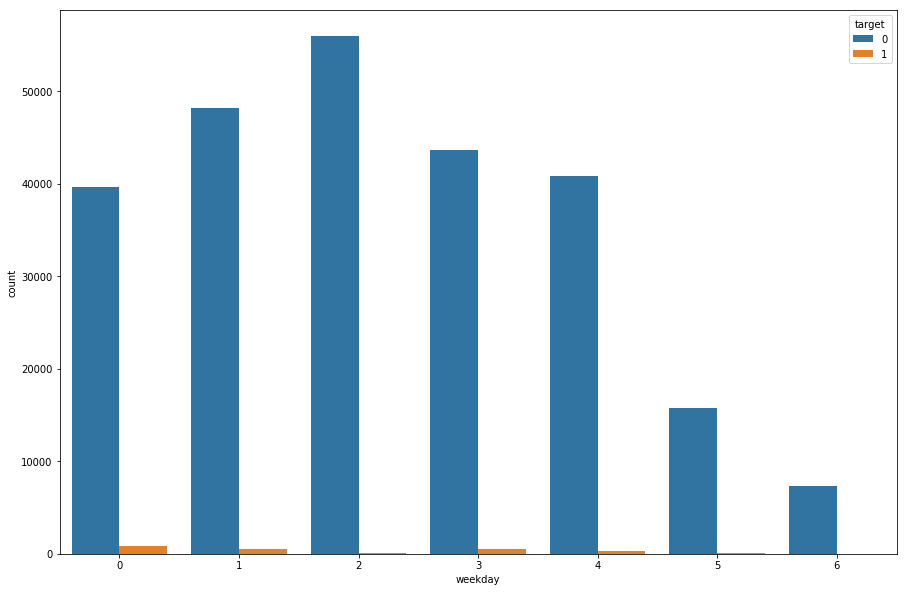

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(x='weekday', hue='target', data=graph_train);

In [7]:
graph_train['year_month'] = [str(d.year) +str(d.month) if d.month >= 10 
                             else str(d.year) + '0' + str(d.month) for d in graph_train['time1']]

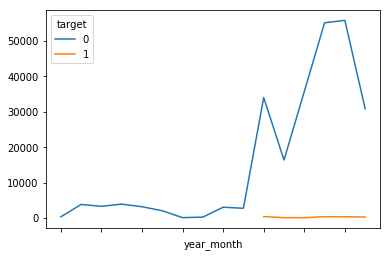

In [8]:
graph_train.pivot_table(index='year_month', values='site1', 
                     aggfunc='count', columns='target').plot();

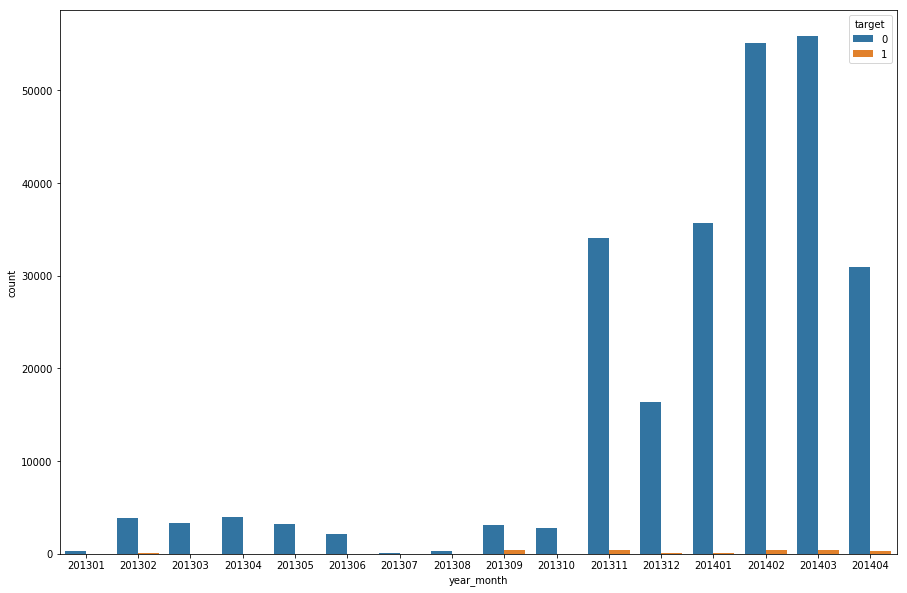

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(x='year_month', hue='target', data=graph_train);

In [48]:
graph_train[graph_train['target'] == 1]['year_month'].value_counts()

201311    446
201402    410
201403    400
201309    377
201404    302
201312    134
201401    129
201302     61
201304     38
Name: year_month, dtype: int64

In [23]:
graph_test = X_test.copy()
graph_test['start_time'] = [d.hour for d in graph_test['time1']]
graph_test['year_month'] = [str(d.year) +str(d.month) if d.month >= 10 
                        else str(d.year) + '0' + str(d.month) for d in graph_test['time1']]

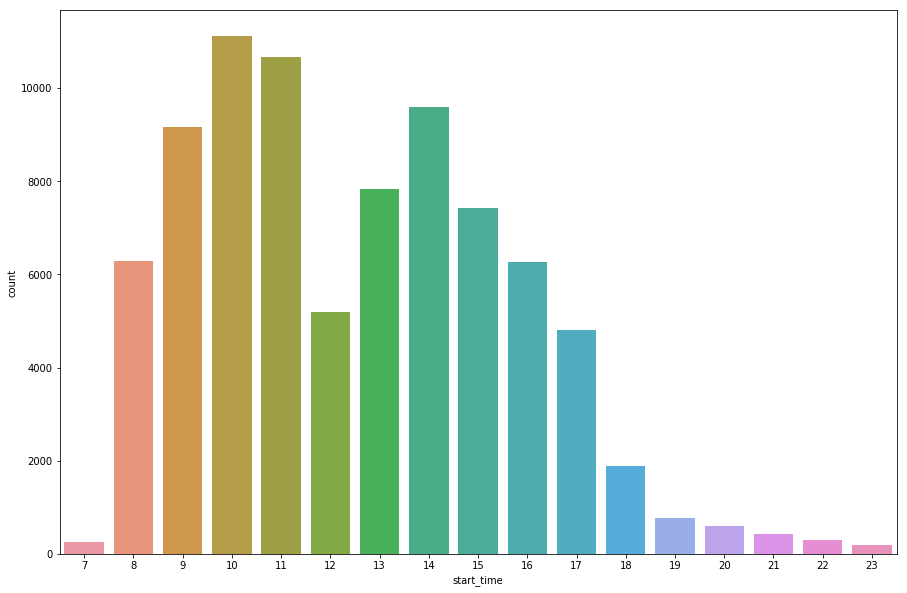

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(x='start_time', data=graph_test);

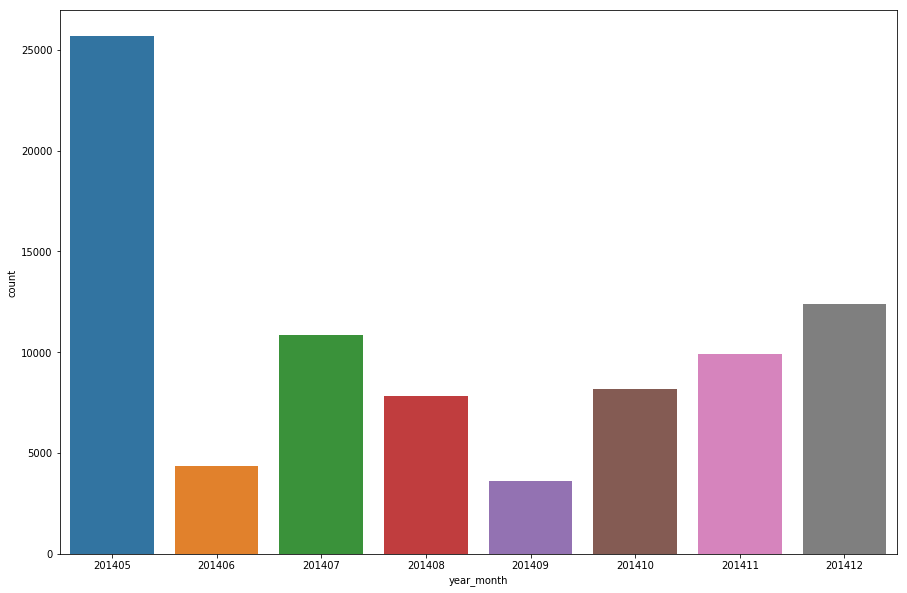

In [12]:
plt.figure(figsize=(15,10))
sns.countplot(x='year_month', data=graph_test);

In [6]:
site_dict = dict([(v, k) for (k, v) in site_dict.items()])
X_train, y_train = train_df.drop('target', axis=1), train_df['target']
X_test = test_df.copy()

for i in sites:
    X_train[i] = X_train[i].map(site_dict)
    X_test[i] = X_test[i].map(site_dict)

In [11]:
X_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,safebrowsing.clients.google.com,2013-01-12 08:05:57,safebrowsing-cache.google.com,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
54843,safebrowsing.clients.google.com,2013-01-12 08:37:23,safebrowsing-cache.google.com,2013-01-12 08:37:23,safebrowsing.clients.google.com,2013-01-12 09:07:07,safebrowsing-cache.google.com,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
77292,www.apache.org,2013-01-12 08:50:13,www.apache.org,2013-01-12 08:50:14,download.eclipse.org,2013-01-12 08:50:15,www.apache.org,2013-01-12 08:50:15,www.apache.org,2013-01-12 08:50:16,www.webtide.com,2013-01-12 08:50:16,download.oracle.com,2013-01-12 08:50:16,javadl-esd-secure.oracle.com,2013-01-12 08:50:16,www.caucho.com,2013-01-12 08:50:17,www.apache.org,2013-01-12 08:50:17
114021,www.webtide.com,2013-01-12 08:50:17,download.oracle.com,2013-01-12 08:50:17,www.caucho.com,2013-01-12 08:50:18,download.oracle.com,2013-01-12 08:50:18,www.webtide.com,2013-01-12 08:50:18,www.apache.org,2013-01-12 08:50:18,public.dhe.ibm.com,2013-01-12 08:50:19,www.webtide.com,2013-01-12 08:50:19,www.apache.org,2013-01-12 08:50:19,www.apache.org,2013-01-12 08:50:20
146670,public.dhe.ibm.com,2013-01-12 08:50:20,jope.ow2.org,2013-01-12 08:50:20,download.oracle.com,2013-01-12 08:50:20,public.dhe.ibm.com,2013-01-12 08:50:21,jope.ow2.org,2013-01-12 08:50:21,master.dl.sourceforge.net,2013-01-12 08:50:21,www.apache.org,2013-01-12 08:50:21,download.eclipse.org,2013-01-12 08:50:22,www.apache.org,2013-01-12 08:50:22,public.dhe.ibm.com,2013-01-12 08:50:22


In [7]:
X_train['sites'] = X_train['site1']
X_test['sites'] = X_test['site1']
for i in sites[1:]:
    X_train['sites'] += ' ' + X_train[i].fillna('')
    X_test['sites'] += ' ' + X_test[i].fillna('')

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=120000)

X_train_vect = vectorizer.fit_transform(X_train['sites'])
X_test_vect = vectorizer.transform(X_test['sites'])

In [25]:
logit = LogisticRegression(C=12.915, random_state=17)
time_split = TimeSeriesSplit(n_splits=10)

In [30]:
%%time
score = cross_val_score(estimator=logit, X=X_train_vect, y=y_train, cv=time_split, scoring='roc_auc')

Wall time: 3min 38s


In [31]:
score, score.mean()

(array([0.82450943, 0.6756266 , 0.86043665, 0.95666276, 0.84435929,
        0.87248499, 0.91744283, 0.87412565, 0.92845389, 0.92990928]),
 0.8684011376123181)

In [10]:
def add_time_features(df):
    X = df[['time1']]
    X['start_time'] = [d.hour for d in X['time1']]
    X['morning'] = [1 if 7 <= d <= 11 else 0 for d in X.start_time]
    X['day'] = [1 if 12 <= d <= 18 else 0 for d in X.start_time]
    X['evening'] = [1 if 19 <= d <= 23 else 0 for d in X.start_time]
    X['danger_time'] = [1 if 9 <= d <= 18 else 0 for d in X.start_time]
    X['weekday'] = [d.weekday() for d in X['time1']]
    features = ['morning', 'day', 'evening']
    X = pd.get_dummies(X, columns=['start_time', 'danger_time', 'weekday'])
    X = X.drop('time1', axis=1)
    
    return X

In [11]:
%%time
X_train_add = add_time_features(X_train.fillna(0))
X_test_add = add_time_features(X_test.fillna(0))

Wall time: 2min 32s


In [32]:
X_train_new = hstack([X_train_vect, X_train_add])
X_test_new = hstack([X_test_vect, X_test_add])

In [14]:
%%time
score = cross_val_score(estimator=logit, X=X_train_new, y=y_train, cv=time_split, scoring='roc_auc')

Wall time: 2min 2s


In [15]:
score, score.mean()

(array([0.65332824, 0.89378088, 0.9196334 , 0.96396162, 0.93523465,
        0.97843264, 0.89823984, 0.95820177, 0.83468821, 0.98199382]),
 0.9017495068380816)

In [33]:
logit.fit(X_train_new, y_train)

LogisticRegression(C=12.915, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
test_pred = logit.predict_proba(X_test_new)[:, 1]

In [13]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [14]:
%%time
logit_grid_searcher.fit(X_train_new, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 29.6min finished


Wall time: 30min 36s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [15]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9063002102819764, {'C': 12.915496650148826})

In [16]:
test_pred = logit_grid_searcher.predict_proba(X_test_new)[:, 1]

In [17]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [35]:
write_to_submission_file(test_pred, "alice.csv")